# 🔎🔢 Hands-On Tokenizers (in Deep Learning)

**Table of Contents**
- [📖 Introduction](#intro)
- [🛠️ Install common librairies](##install)
- [👨‍💻 Helpers to inspect tokenizers](#helpers)
- [👀 Inspect tokenizers](#start)
  - [🔬📚 See vocabulary of (small) tokenizers](#vocabulary)
  - [🔬🕹️ See how tokenizers do tokenize texts](#️examples)
  - [🔬☪ Tokenization with Arabic (and code-switching)](#arabic)
  - [🔬🤼 Challenge tokenizers](#challenge)
  - [🧪🏆 Benchmark fertility](#benchmark)
  - [🔢💬 Chat templates](#templates)
  - [🔢✂️ Padding and Truncation](#padding)
  - [🤖🧠 Train a new tokenizer](#training)
  - [🤖👩🏻‍⚕️ Tokenizer Surgery](#surgery)
  

<!-- ## 📖 Introduction -->
<h2 id="intro">📖 Introduction</h2>

A tokenizer maps `string` $\rightleftharpoons$ `list of tokens`.
* `encode`("string") $\mapsto$ ["list", "of", "tokens"]
* `decode`(["list", "of", "tokens"]) $\mapsto$ "string"

In deep learning, a tokenizer is a <u>pre-processing</u> and/or <u>post-processing</u> brick for an artificial neural network that process and/or generates text.

In DeepLearning/NLP, a token is a unit of text (sequence of characters or bytes) that is often characterized by:
* an <u>index in the vocabulary</u> of tokens,
* a string representer (for interpretability).

The index is used to interpret inputs and/or outputs of a neural network.
<br> It is a positive integer in a limited range, that is often used to index vectorial embeddings (as input: lookup table / as output: index in vector of probabilities).
<br> The *encoding* part is used when the neural net is fed with text data (ex: Language Models).
<br> The *decoding* part is used when the neural net outputs text data (ex: Text Generation with LM, Automatic Speech Recognition, Image Caption Generation, ...).

When extracted from a string, a token can also be characterized the <u>positions in the original string</u> (start & end). <br>
This is needed for application like extractive question answering, where we have to track the position of the answer in the original text to extract it. <br>
(Caution with multi-bytes characters: position in bytes is not the same as position in characters.)

A good tokenizer can compress a string into a small number of tokens,
while keeping a reasonable vocabulary size (number of possible unique tokens). <br>
A popular measure of this efficiency is the <u>fertility</u> of the tokenizer, defined as the average number of tokens per word:
$$\text{fertility} = \frac{\text{number of tokens}}{\text{number of words}}$$

The main problem of having a vocabulary with a limited size (and hard to grow) is <u>out-of-vocabulary (OOV)</u>,
which neither word- nor character-level tokenizers can solve:
* Each natural language uses between 100k and 100M words, so it is impossible to have a vocabulary that covers all words.
* Even at the character level there about 150k unicode characters!

A solution to the OOV problem is to work at <u>byte-level</u> (unicode), not character-level. <br>
In state-of-the-art models, tokens are often <u>sub-word tokens</u>, 
* either at byte-level (so a token can be a "sub-character"), 
* or at character-level with a byte-level fallback for unicode characters that are not in the vocabulary.

The table below show several levels of tokenization and illustrates that a trade-off must be found between vocabulary size and tokens'sequence lengths.

In [13]:
input = "Tout à 1€"

def tokenization_level_tradeoff_table(input):

    import pandas as pd
    pd.set_option('display.max_colwidth', None)

    def display_tokenized(l):
        out = "┃".join([str(t) for t in l])
        if len(l) > 20:
            try:
                out = out[:out.index("┃", 60)+1] + "..."
            except: pass
        return out

    def flatten(l):
        return [item for sublist in l for item in sublist]

    def decode_utf8(byte):
        try:
            return bytes([byte]).decode('utf-8')
        except:
            return "�"
        
    columns = ["Token-level", "Max.Vocab.Size", "OOV", "Seq.Length", "Example", " "]
    data = [
        ["Bit",         2,      "🟢", "🔴", flatten([[int(bit) for bit in format(ord(char), '08b')] for char in input])     ],
        ["UTF8 Byte",   256,    "🟢", "🟠", [f"{idx} ({decode_utf8(idx).replace(' ','▁')})" for idx in list(input.encode("utf-8"))]          ],
        ["Unicode",    "155k+", "🟡", "🟡", list(input)                                                                     ],
        ["Sub-word",   "300k+", "🟡", "🟢", flatten([["▁"]+list(word) if any(char.isdigit() for char in word) else [("▁"if i == 0 else "")+word[i:i+2] for i in range(0, len(word), 2)] for word in input.split()]) ],
        ["Word",       "1M+",   "🟠", "🟢", ["▁"+word for word in input.split()]                                            ],
        ["Phrase",     "∞",     "🔴", "🟢", ["▁"+"▁".join(input.split()[:2])] + ["▁"+word for word in input.split()[2:]]   ],
    ]

    note_column = ["long sequences /", "few possible values"] + [""] * (len(data) - 4) + ["short sequences /", "many possible values"]
    note_column_2 = ["⬆️"] + [""] * (len(data) - 2) + ["⬇️"]
    last_column = [f"[{len(t[-1])}]" for t in data]

    data = [
        [note] + cols[:-1] + [display_tokenized(cols[-1]), last_col]
        for note, cols, last_col in zip(note_column_2, data, last_column)
    ]

    return pd.DataFrame(
        dict((col, [v[icol] for v in data]) for (icol, col) in enumerate([""] + columns)),
        index = note_column
    )

print(f"Different tokenizations of '{input}':")
tokenization_level_tradeoff_table(input)

Different tokenizations of 'Tout à 1€':


,,Token-level,Max.Vocab.Size,OOV,Seq.Length,Example,
long sequences /,⬆️,Bit,2,🟢,🔴,0┃1┃0┃1┃0┃1┃0┃0┃0┃1┃1┃0┃1┃1┃1┃1┃0┃1┃1┃1┃0┃1┃0┃1┃0┃1┃1┃1┃0┃1┃0┃...,[78]
few possible values,,UTF8 Byte,256,🟢,🟠,84 (T)┃111 (o)┃117 (u)┃116 (t)┃32 (▁)┃195 (�)┃160 (�)┃32 (▁)┃49 (1)┃226 (�)┃130 (�)┃172 (�),[12]
,,Unicode,155k+,🟡,🟡,T┃o┃u┃t┃ ┃à┃ ┃1┃€,[9]
,,Sub-word,300k+,🟡,🟢,▁To┃ut┃▁à┃▁┃1┃€,[6]
short sequences /,,Word,1M+,🟠,🟢,▁Tout┃▁à┃▁1€,[3]
many possible values,⬇️,Phrase,∞,🔴,🟢,▁Tout▁à┃▁1€,[2]


#### 🤓 Implementation of dummy a tokenizer (tokens=characters/words)
The decomposition of a string into tokens can be illustrated in this small code, where tokens can be words/characters:

In [ ]:
class CharSplitter:

    def split(self, text: str) -> list:
        return list(text)

    def join(self, tokens: list) -> str:
        return "".join(tokens)

class WordSplitter:

    _SPACE = "▁"

    def split(self, text: str) -> list:
        words = text.split(" ")
        return ([words[0]] + [self._SPACE+w for w in words[1:]]) if words else []
        
    def join(self, tokens: list) -> str:
        return "".join(tokens).replace(self._SPACE, " ")

input = "Mais, mais… vas t'en là-bas !"

for tokenizer in [CharSplitter(), WordSplitter()]:

    encoded = tokenizer.split(input)

    # Round-trip test
    encoded_decoded = tokenizer.join(encoded)
    assert encoded_decoded == input
    
    print(f"== {tokenizer.__class__.__name__} ==\n➡️ {encoded}\n➡️ {encoded_decoded}\n")

This was to show the string decomposition principle.

In reality, tokenizers are more complex when they are used with a neural network model, because of the vocabulary that has a **fixed size**.

In [ ]:
class Tokenizer:

    _SOS = "<start>"
    _EOS = "<end>"
    _UNK = "<unk>"
    vocabulary = [_UNK, _SOS, _EOS]
   
    def encode(self, text: str) -> list:
        # Dec
        tokens_str = self.split(text)
        tokens_idx = [
            self.vocabulary.index(t) if t in self.vocabulary
            else self.vocabulary.index(self._UNK)
            for t in tokens_str
        ]
        return tokens_idx
        
    def encode_str(self, text: str) -> list:
        return [self.vocabulary[idx] for idx in self.encode(text)]

class CharTokenizer(Tokenizer, CharSplitter):

    def __init__(self, vocabulary: list = [chr(i) for i in range(128)]):
        self.vocabulary += vocabulary

In [ ]:
input = "Mais, mais… vas t'en là-bas !"

tokenizer = CharTokenizer()
encoded = tokenizer.encode(input)
encoded_str = tokenizer.encode_str(input)
encoded_decoded = tokenizer.join(encoded_str)
print(f"{input}\n➡️ {encoded}\n➡️ {encoded_str}\n➡️ {encoded_decoded}")

<h2 id="install">🛠️ Install common librairies</h2>

Popular python libraries for tokenizers are:

In [ ]:
# Most popular tokenizer libraries
!pip install tokenizers>=0.20,<0.21 # last version is buggy
!pip install tiktoken #==0.8.0
!pip install sentencepiece #==0.2.0

# Librairies for neural networks that include tokenizers (usually wrap other lower-level tokenization libraries)
!pip install transformers #==4.46.3
# !pip install nemo #==6.0.3
!pip install git+https://github.com/linagora-labs/NeMo.git pytorch_lightning==2.4.0 lhotse==1.28.0
#!python -m pip install git+https://github.com/linagora-labs/NeMo.git@{main}#egg=nemo_toolkit[asr]

Check versions:

In [ ]:
!pip index versions tiktoken 2> /dev/null
!pip index versions tokenizers 2> /dev/null
!pip index versions sentencepiece 2> /dev/null

# !pip index versions transformers 2> /dev/null
# !pip index versions nemo 2> /dev/null

Also useful for this notebook:

In [ ]:
!pip install matplotlib
!pip install pandas
!pip install tqdm

<!-- ## 👨‍💻 Helpers to inspect tokenizers -->
<h2 id="helpers">👨‍💻 Helpers to inspect tokenizers</h2>

Define a list of interesting tokenizers, identified either by their tiktoken name or [Hugging Face repository name](https://huggingface.co/docs/huggingface_hub/en/guides/repository):

In [4]:
import os

my_tokenizers = {
    
    # LLM - TikToken
    "GPT 3.5":  "gpt-3.5-turbo",
    "GPT 4":    "gpt-4",
    
    # LLM - Hugging Face / transformers (prefix with "https://huggingface.co/" to get the model card URL)
    "Lucie":        "OpenLLM-France/Lucie-7B",   # -> https://huggingface.co/OpenLLM-France/Lucie-7B
    "Gemma":        "google/gemma-7b",
    "Phi 2":        "microsoft/phi-2",
    "Phi 3":        "microsoft/Phi-3-medium-4k-instruct",
    "Qwen":         "Qwen/Qwen2.5-7B",
    "Falcon":       "tiiuae/falcon-7b",
    "Mistral":      "mistralai/Mistral-7B-Instruct-v0.3", # "mistralai/Mistral-7B-v0.1",
    "Llama 2":      "meta-llama/Llama-2-7b-hf",
    "Llama 3":      "meta-llama/Meta-Llama-3-8B-Instruct",
    "Croissant":    "croissantllm/CroissantLLMBase",
    "Bloom":        "bigscience/bloom-7b1",
    "Olmo 2":       "allenai/OLMo-2-1124-7B-Instruct",
    "C4":           "CohereForAI/c4ai-command-r-plus",
    "Aya":          "CohereForAI/aya-expanse-8b",
    "Jais":         "inceptionai/jais-adapted-7b-chat",
    "EuroLLM":      "utter-project/EuroLLM-9B",
    "Zephyr":       "HuggingFaceH4/zephyr-7b-beta",

    # ASR - Hugging Face / transformers
    "Whisper":      "openai/whisper-large-v3",
    # ASR - Hugging Face / nemo
    "Parakeet":     "nvidia/parakeet-ctc-1.1b", # same as "nvidia/parakeet-rnnt-1.1b",
}
custom_tokenizers = { # Custom file paths
    "🐦 Perruche":     f"{os.environ['HOME']}/projects/Parakeet/tokenizer_spe_bpe_v1024/tokenizer.model",
}

for name, file_or_folder in custom_tokenizers.items():    
    if not os.path.exists(file_or_folder):
        print("WARNING: {name} is not available at {file_or_folder}")
        continue
    my_tokenizers[name] = file_or_folder

**Note:** some models (like [Llama](https://huggingface.co/meta-llama/Llama-3.1-8B-Instruct)) might require to fill some agreements form to have access to the model (with your Hugging Face account).<br>
In case of problem, you should have an explicit message with the URL to visit (and fill the form) to get access to the model.


Below are defined some helpers to load and play with tokenizers:
* Create tokenizer:
    * `load_tokenizer`( `tokenizer_name` ): load a tokenizer from its name (either a Hugging Face repository name or a token name).
    * `load_tokenizer_with_cache`( `tokenizer_name` ): same thing with a cache to avoid downloading the same tokenizer multiple times.
* Inspect tokenizer vocabulary:
    * `vocabulary_size`( `tokenizer_name` ): get the number of tokens in the vocabulary.
    * `get_vocabulary`( `tokenizer_name` ): return the list of tokens.
    * `sorted_vocabulary`( `tokenizer_name` ): return the tokens sorted by length and alphabetically, in a table **(for small tokenizers only)**.
* Apply tokenizer:
    * `encode_decode`( `tokenizer_name` , `text` ): encode and decode a text with a tokenizer, returning all the intermediate steps.
    * `show_templates`( `tokenizer_name`［, `chat`］): show chat templates of tokenizer(s) (see dedicated section later).

In [5]:
import pandas as pd

def conform_tokenizer_name(name):
    global my_tokenizers
    if name in my_tokenizers:
        return my_tokenizers[name]
    return name

def load_tokenizer(name):
    """
    Load a tokenizer by name.
    """
    # Conform name
    name = conform_tokenizer_name(name)

    # Load with the right library
    # - TikToken
    if name.lower().startswith("gpt"):
        import tiktoken
        return tiktoken.encoding_for_model(name.lower())
    # - SentencePiece
    elif name.endswith(".model"):
        import sentencepiece as spm
        return spm.SentencePieceProcessor(model_file=name)
    # - NeMo
    elif name.lower().startswith("nvidia"):
        import nemo.collections.asr as nemo_asr
        import logging
        logging.getLogger('nemo_logger').setLevel(logging.ERROR)
        if "ctc" in name:
            nemo_model_class = nemo_asr.models.EncDecCTCModelBPE
        elif "rnn" in name:
            nemo_model_class = nemo_asr.models.EncDecRNNTBPEModel
        else:
            raise NotImplementedError(f"NeMo model '{name}' not supported")
        model = nemo_model_class.from_pretrained(name)
        return model.tokenizer.tokenizer
    # - Transformers
    else:
        import transformers
        try:
            return transformers.AutoTokenizer.from_pretrained(name, trust_remote_code=True)
        except Exception as err:
            # Report the name in case of error
            raise RuntimeError(f"Could not load tokenizer '{name}': {err}") from err

def load_tokenizer_with_cache(name):
    """
    Load a tokenizer by name, with cache.
    """
    global _loaded_tokenizers
    if name not in _loaded_tokenizers:
        _loaded_tokenizers[name] = load_tokenizer(name)
    return _loaded_tokenizers[name] 

if "_loaded_tokenizers" not in globals(): _loaded_tokenizers = {}

def get_token_representer(tokenizer, idx, if_negative="<BOS>"):
    """
    Get the token string corresponding to an index.
    """
    if isinstance(tokenizer, str):
        tokenizer = load_tokenizer_with_cache(tokenizer)
    if idx < 0: return if_negative
    
    representer = ""
    if "id_to_token" in dir(tokenizer):
        representer = tokenizer.id_to_token(idx)
    elif "convert_ids_to_tokens" in dir(tokenizer):
        representer = tokenizer.convert_ids_to_tokens([idx])
    try:
        decoded = tokenizer.decode([idx], skip_special_tokens=False)
    except Exception as err:
        decoded = tokenizer.decode([idx])
    while isinstance(representer, list):
        assert len(representer) == 1
        representer = representer[0]
    while isinstance(decoded, list):
        assert len(decoded) == 1
        decoded = decoded[0]
    representer = normalize_for_display(representer, is_token=True)
    decoded = normalize_for_display(decoded, is_token=True)
    if not decoded.startswith("▁") and representer.startswith("▁"):
        decoded = "▁" + decoded
    if not decoded.endswith("▁") and representer.endswith("▁"):
        decoded += "▁"
    return decoded    

def encode_decode(tokenizer, text, add_special_tokens=True, **kwargs):
    """
    Round-trip testing:
    Encode an input text into a list of tokens, and decode the tokens back to a string.
    """
    if isinstance(tokenizer, str):
        tokenizer = load_tokenizer_with_cache(tokenizer)

    if "encode_batch" in dir(tokenizer):
        # TikToken
        tokens = tokenizer.encode_batch(
            [text],
            allowed_special="all" if add_special_tokens else set(),
            disallowed_special=(),
            **kwargs
        )[0]
        if hasattr(tokens, "ids"):
            tokens = tokens.ids
        decoded = tokenizer.decode(tokens)
    elif "SentencePiece" in type(tokenizer).__name__:
        # SentencePiece
        tokens = tokenizer.encode(text,
            add_bos=add_special_tokens,
            add_eos=add_special_tokens,
            emit_unk_piece=add_special_tokens,
            **kwargs
        )
        decoded = tokenizer.decode([t for t in tokens if t >= 0])
        # tokens_strings = tokenizer.encode(text,
        #     out_type=str,
        #     emit_unk_piece=add_special_tokens,
        # )
    else:
        # transformers / tokenizers
        tokenizer.add_eos_token = bool(add_special_tokens)
        tokens = tokenizer.encode(text, add_special_tokens=add_special_tokens, **kwargs)
        decoded = tokenizer.decode(tokens, skip_special_tokens=not add_special_tokens)
    
    # Normalize for display
    tokens_strings = [get_token_representer(tokenizer, idx, "<BOS>" if i == 0 else "<SOS>") for i, idx in enumerate(tokens)]
    # Note : get_token_representer is already calling the equivalent of normalize_for_display(tokens_strings, is_token=True)
    tokens_strings = normalize_for_display(tokens_strings, is_token=True, is_normalized=True)
    norm_decoded = normalize_for_display(decoded)

    return tokens, tokens_strings, decoded, norm_decoded

def vocabulary_size(tokenizer, to_string=False):
    """
    Get the vocabulary size of a tokenizer.
    """
    if isinstance(tokenizer, str):
        tokenizer = load_tokenizer_with_cache(tokenizer)
    
    N = None
    for attr_name in "n_vocab", "vocab_size", "get_vocab_size":
        if attr_name in dir(tokenizer):
            N = getattr(tokenizer, attr_name)
            if not isinstance(N, int):
                assert callable(N)
                N = N()
            break
    if not N:
        raise NotImplementedError(f"Vocabulary not supported for tokenizer '{tokenizer}'")
    if to_string:
        def format_thoushands(N):
            import math
            if N < 1100:
                return str(N)
            if N - 1000 * math.floor(N/1000) < 100:
                return f"{N//1000}k"
            return f"{N/1000:.1f}k"
        N = format_thoushands(N)
    return N

def get_vocabulary(tokenizer):
    """
    Get the vocabulary of a tokenizer.
    """
    if isinstance(tokenizer, str):
        tokenizer = load_tokenizer_with_cache(tokenizer)

    N = vocabulary_size(tokenizer)
    try:
        tokens_str = [tokenizer.decode([t], skip_special_tokens=False) for t in range(N)]
    except Exception as err:
        tokens_str = [normalize_for_display(tokenizer.decode([t]), is_token=True) for t in range(N)]
    if "id_to_piece" in dir(tokenizer):
        tokens_str_check = [normalize_for_display(tokenizer.id_to_piece(t), is_token=True) for t in range(N)]
        for i, (t1, t2) in enumerate(zip(tokens_str, tokens_str_check)):
            if t1 != t2:
                if not t1.startswith("▁") and t2.startswith("▁"):
                    tokens_str[i] = "▁" + tokens_str[i]
    
    tokens_str = [normalize_for_display(tok, is_token=True) for tok in tokens_str]
    return tokens_str

def sorted_vocabulary(tokenizer):
    vocab = get_vocabulary(tokenizer)
    tokens_by_length = {}
    for token in vocab:
        nchars = len(token.lstrip("▁"))
        sow = token.startswith("▁")
        key = (nchars, sow)
        if key not in tokens_by_length:
            tokens_by_length[key] = []
        tokens_by_length[key].append(token)

    data = []
    for (nchars, sow) in sorted(tokens_by_length):
        tokens = sorted(tokens_by_length[(nchars, sow)])
        data.append({
            "nchars": nchars,
            "start": "▶" if sow else "#…",
            "#tokens": len(tokens),
            "tokens": tokens # normalize_for_display(tokens, is_token=True),
        })

    data.append({
        "nchars": "TOTAL",
        "start": "",
        "#tokens": sum(d["#tokens"] for d in data),
        "tokens": "",
    })
    
    return pd.DataFrame(data)

def show_templates(tokenizers=my_tokenizers, chat=None):
    if isinstance(tokenizers, str):
        tokenizers = [tokenizers]
    exemple_chat = chat if chat else [
        {"role": "user", "content": "Hello robot"},
        {"role": "assistant", "content": "Hello human! How can I help?"},
        {"role": "user", "content": "Make me a coffee"},
    ]
    empty_chat = [
        {"role": "user", "content": "."},
        {"role": "assistant", "content": "."},
    ]
    for tokenizer in tokenizers:
        title = f"👤 {tokenizer}:"
        print("\n" + title + "\n" + "-"*(len(title)+2))
        tokenizer = load_tokenizer_with_cache(tokenizer)
        try:
            templated_chat = tokenizer.apply_chat_template(exemple_chat, tokenize=False)
        except Exception as err:
            # Templated chat is not supported by all tokenizers
            print(f"❌ Error with {conform_tokenizer_name(tokenizer)}: {err}")
            continue
        # Split into turns
        print(templated_chat)
        ignore_index, _, _, _ = encode_decode(tokenizer, ".", add_special_tokens=False)
        ignore_index = ignore_index[-1:]
        encoded, tokens_str, _, _ = encode_decode(tokenizer, templated_chat, add_special_tokens=False)
        encoded0, tokens_str0, _, _ = encode_decode(tokenizer, tokenizer.apply_chat_template(empty_chat, tokenize=False), add_special_tokens=False)
        current = 0
        special_tokens_str = [[]]
        after_token_str = [[]]
        tokens_str0 = tokens_str0.split("┃")
        tokens_str = tokens_str.split("┃")
        assert len(tokens_str0) == len(encoded0), f"{len(tokens_str0)} ≠ {len(encoded0)}"
        for (tok_str, tok_idx) in zip(tokens_str0, encoded0):
            if tok_idx in ignore_index:
                continue
            if current < len(encoded) and tok_idx != encoded[current] and tok_idx in encoded:
                while current < len(encoded) and tok_idx != encoded[current]:
                    after_token_str[-1].append(tokens_str[current])
                    current += 1
                if special_tokens_str[-1]:
                    special_tokens_str.append([])
                    after_token_str.append([])
            special_tokens_str[-1].append(tok_str)
            current += 1
        for i, (special, after) in enumerate(zip(special_tokens_str, after_token_str)):
            print(
                "💬",
                normalize_for_display(special, is_token=True),
                "┃《…》" if after else "" #, f"{normalize_for_display(after, is_token=False)}"
            )

# Will be defined later
if "normalize_for_display" not in globals():
    def normalize_for_display(text, *kargs, **kwargs): return text

Below are defined helpers to apply tokenizers to a text.
* `test_tokenizers`(`text`, `tokenizers`)`: round-trip encode/decode test on a text, for each tokenizer (displayed in a table).
* `test_tokenizers_batch`(`tests`, `tokenizers`)`: same thing on a list of texts (as a dictionary, with keys as a text name, describing what you want to test).
* `benchmark_fertility`(`dataset_configts`)`: compute the fertility of a tokenizer on a dataset or a list of datasets (displayed in a bar chart).

In [6]:
import datasets
import json, os, re
import matplotlib.pyplot as plt
import tqdm

# Disable datasets progress bars
from datasets.utils.logging import disable_progress_bar
disable_progress_bar()

# Tune display of pandas DataFrames (tables)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.colheader_justify', 'left') # WTF ? this does not work
# pd.set_option('display.show_index', False) # Is there an option to avoid printing the index column of DataFrame?

def test_tokenizers(
    text,
    tokenizers=my_tokenizers,
    display_vocabulary_size=True,
    display_fertility=True,
    display_round_trip_result=True,
    **kwargs
    ):
    if isinstance(tokenizers, str):
        tokenizers = [tokenizers]
    # Build a table with the encoded and decoded text for each tokenizer
    has_comments = False
    all_data = []
    for tokenizer in tokenizers:
        tokens, tokens_str, decoded_raw, decoded = encode_decode(tokenizer, text, **kwargs)
        data = {
            "tokenizer": tokenizer,
        }
        if display_vocabulary_size:
            data["size"] = vocabulary_size(tokenizer, True)
        if display_fertility:
            num_words = len(text.split())
            num_tokens = len(tokens)
            if tokens_str.startswith("<BOS>"):
                num_tokens -= 1
            if tokens_str.endswith("<EOS>"):
                num_tokens -= 1
            data["#tokens"] = num_tokens
            data["fert."] = round(num_tokens / num_words, 1)
        if display_round_trip_result:
            # Remove all tags in brackets (like <BOS>, <EOS>, <UNK>, ...)
            normalized_decoded = re.sub(r"<[^>]*>", "", decoded_raw).strip()
            text_strip = text.strip()
            round_trip_ok = (normalized_decoded == text_strip)
            
            # Spot difference in the round-trip test in case of failure
            diff_string = ""
            if not round_trip_ok:
                start1 = 0
                start2 = 0
                while start1 < len(text_strip) and start2 < len(normalized_decoded) and text_strip[start1] == normalized_decoded[start2]:
                    start1 += 1
                    start2 += 1
                end1 = len(text_strip)
                end2 = len(normalized_decoded)
                while end1 > start1 and end2 > start2 and text_strip[end1-1] == normalized_decoded[end2-1]:
                    end1 -= 1
                    end2 -= 1

                orig = cut_long_string(normalize_for_display(text_strip[start1:end1], is_token=True), 10)
                new = cut_long_string(normalize_for_display(normalized_decoded[start2:end2], is_token=True), 10)

                if "<UNK>" in decoded:
                    diff_string = "OOV"
                elif not orig:
                    diff_string = f"«{new}» added (char {start2+1}/{len(normalized_decoded)})"
                elif not new:
                    diff_string = f"«{orig}» removed (char {start1+1}/{len(text_strip)})"
                else:
                    diff_string += "«"
                    diff_string += orig
                    diff_string += "» ≠ «"
                    diff_string += new
                    diff_string += "»"
            
            # Look if there are weird mixed tokens
            weird_tokens = ""
            _descr_mix_punc = "mix alpha/punct"
            _descr_mix_num = "mix alpha/num"
            _descr_more_than_1_digits = "digits"
            for t in tokens_str.split("┃"):
                t = t.replace("\\n", "\n").replace("\\t", "\t").replace("\\r", "\r") # grrr
                # mix of alphanum and punctuation
                if _descr_mix_punc not in weird_tokens and any(c.isalnum() for c in t) and any(c in ".,;:!?…\n\t" for c in t):
                    if weird_tokens: weird_tokens += ", "
                    weird_tokens += _descr_mix_punc
                # mix of alpha and numeric
                if _descr_mix_num not in weird_tokens and any(c.isalpha() for c in t) and any(c.isdigit() for c in t):
                    if weird_tokens: weird_tokens += ", "
                    weird_tokens += _descr_mix_num
                # more than one digit
                if _descr_more_than_1_digits not in weird_tokens and sum(c.isdigit() for c in t) > 1:
                    if weird_tokens: weird_tokens += ", "
                    weird_tokens += _descr_more_than_1_digits

            is_ok = (round_trip_ok and not weird_tokens)
            if not is_ok:
                has_comments = True

            data["round-trip"] = "✅" if is_ok else ("❌" if not round_trip_ok else "⚠️")
            data["comment"] = diff_string if not round_trip_ok else weird_tokens
        data["encoded tokens"]= cut_long_string(tokens_str)
        data["decoded text"]= cut_long_string(decoded)
        all_data.append(data)

    all_data = pd.DataFrame(all_data)
    if not has_comments:
        all_data = all_data.drop(columns=["comment"])

    return all_data

def cut_long_string(
    text,
    max_len=100,
    separator= "・・・" # "《…》" # "«…»"
    ):
    if len(text) > max_len:
        return text[:max_len//2] + separator + text[-max_len//2:]
    return text

def test_tokenizers_batch(
    tests,
    tokenizers=my_tokenizers,
    sort_by_tokenizer=False,
    **kwargs
    ):

    combined_results = {
        "TEST": [],
        "tokenizer": [],
        "size": [],
        "fert.": [],
        "round-trip": [],
        "comment": [],
        "encoded tokens": [],
        "decoded text": [],
    }
    for name, text in tqdm.tqdm(tests.items(), desc="Testing tokenizers", unit="test") if (len(tokenizers) * len(tests) > 10) else tests.items():
        df = test_tokenizers(text, tokenizers, **kwargs)
        
        # Sort by fertility, and by tokenizer size if fertilities are equal
        df['tmp'] = df['size'].apply(lambda x: eval(x.replace('k', '*1000').replace(' ', '')))
        df = df.sort_values(by=["fert.", "tmp"], ascending=True)
        df = df.drop(columns=['tmp'])

        for k in combined_results:
            if k == "TEST":
                combined_results[k] += [name] * len(df)
            elif k not in df:
                if k in ["comment"]:
                    combined_results[k] += [""] * len(df)
                else:
                    raise ValueError(f"Key '{k}' not found in the DataFrame")
            else:
                combined_results[k] += list(df[k].values)

    combined_results = pd.DataFrame(combined_results)

    if sort_by_tokenizer:
        combined_results = combined_results.sort_values(by=["tokenizer"])

    return combined_results

# Cache benchmark results (that are long to compute)
_file_to_cache_results = "expes/tokenizers_fertilities.json"
def clear_cache():
    global fertilities, _loaded_tokenizers
    fertilities = {}
    if _file_to_cache_results and os.path.exists(_file_to_cache_results):
        with open(_file_to_cache_results, "r") as f:
            fertilities = json.load(f)

    _loaded_tokenizers = {}

if "fertilities" not in globals():
    clear_cache()

def benchmark_fertility(
    dataset_configs, # = [
    #     ("wikimedia/wikipedia", "20231101." + lan)
    #     for lan in ["en", "fr", "de", "es", "it"]
    # ]
    tokenizers=my_tokenizers,
    max_docs = 1000,
    max_characters = 1e6,
    do_not_recompute=True,
    ):
    """
    Measure the fertility of tokenizers on some dataset(s).

    Args:
    - tokenizers: list of tokenizers to test
    - dataset_configs: list of configurations to test. Those are positional arguments for datasets.load_dataset().
    - max_docs: number of documents to test
    - do_not_recompute: if True, will not recompute fertilities if already computed
    """
    global fertilities

    config_names = ["/".join(config) for config in dataset_configs]

    conformed_tokenizers = [conform_tokenizer_name(t) for t in tokenizers]

    if isinstance(dataset_configs, str):
        dataset_configs = [dataset_configs]

    for i_config, (args, config) in enumerate(zip(dataset_configs, config_names)):
        if isinstance(args, str):
            args = (args,)
        # Do not recompute what was already computed
        if do_not_recompute and all(tokenizer in fertilities.get(config, {}) for tokenizer in conformed_tokenizers):
            continue
        already_computed_tokenizers = set(fertilities.get(config, {}))
        num_missing = len(set(conformed_tokenizers) - set(already_computed_tokenizers)) if do_not_recompute \
            else len(conformed_tokenizers)
        if num_missing == 0:
            continue

        # Load the dataset
        dataset = datasets.load_dataset(*args, split="train", streaming=True)
        num_words = 0
        num_tokens = {}
        # Accumulate statistics
        num_characters = 0
        for i_doc, doc in enumerate(tqdm.tqdm(dataset, desc=f"Testing {num_missing} tokenizers on {config}", total=max_docs)):
            if i_doc >= max_docs:
                break
            if num_characters >= max_characters:
                break
            text = doc["text"]
            num_characters += len(text)
            num_words += len(text.split())
            for tokenizer in tokenizers:
                tokenizer_name = conform_tokenizer_name(tokenizer)
                if do_not_recompute and tokenizer_name in already_computed_tokenizers:
                    continue
                tokens = encode_decode(tokenizer, text, add_special_tokens=False)[0]
                assert isinstance(tokens, list) and (not tokens or isinstance(tokens[0], int)), f"Unexpected tokens: {tokens}"
                num_tokens[tokenizer_name] = num_tokens.get(tokenizer_name, 0) + len(tokens)
        fertilities[config] = fertilities.get(config, {})
        for tokenizer_name in num_tokens:
            fertilities[config][tokenizer_name] = num_tokens[tokenizer_name] / num_words
        
        # Sort keys alphabetically
        for c in fertilities.keys():
            fertilities[c] = dict(sorted(fertilities[c].items(), key=lambda item: item[0]))
        fertilities = dict(sorted(fertilities.items(), key=lambda item: item[0]))
        
        # Save results on disk
        if _file_to_cache_results:
            tmp_file = _file_to_cache_results + ".tmp"
            if not os.path.isdir(os.path.dirname(_file_to_cache_results)):
                os.makedirs(os.path.dirname(_file_to_cache_results))
            with open(tmp_file, "w") as f:
                json.dump(fertilities, f, indent=2)
            os.replace(tmp_file, _file_to_cache_results)

    # Plot
    num_cols = 2
    num_rows = (len(dataset_configs)+1)//num_cols
    if len(dataset_configs) % 2 == 0:
        num_rows += 1
    colors = [plt.cm.rainbow(i / len(tokenizers)) for i in range(len(tokenizers))]

    # Sort tokenizers by increasing fertility
    tokenizers = sorted(
        tokenizers,
        key=lambda t: sum(fertilities[config][conform_tokenizer_name(t)] for config in config_names[:2])
    )

    plt.figure(figsize=(12, 6*num_rows))

    # Print one plot per configuration
    max_yaxis = 0
    for i_config, (args, config) in enumerate(zip(dataset_configs, config_names)):
        fert = fertilities[config]
        plt.subplot(num_rows, num_cols, i_config+1)
        for i, (t, color) in enumerate(zip(tokenizers, colors)):
            plt.bar([i+1], [fert[conform_tokenizer_name(t)]], color=color)
        if isinstance(args, str):
            plt.title(args)
        else:
            plt.title(", ".join(args))
        plt.ylabel("Fertility (tokens per word)")
        plt.xticks([i+1 for i in range(len(tokenizers))])
        (y_min, y_max) = plt.ylim()
        max_yaxis = max(max_yaxis, y_max)
    # Rescale all the same
    for i_config in range(len(dataset_configs)):
        plt.subplot(num_rows, num_cols, i_config+1)
        plt.ylim(0, max_yaxis)
    
    # Custom legend
    plt.subplot(num_rows, num_cols, len(dataset_configs)+1)
    for i, (tokenizer, color) in enumerate(zip(tokenizers, colors)):
        plt.bar([0], [0], color=color, label=f"{i+1}. {tokenizer} ({vocabulary_size(tokenizer, True)})")
    plt.legend(fancybox=True, shadow=True, title="Tokenizers", loc='center', fontsize=15, ncol=min(2, len(tokenizers)))
    plt.axis("off")
    plt.show()

Below are some helpers to display things nicely. <br>
There is a special treatment for string including both Arabic and latin characters (so that characters are displayed in the right order).
<br> *(**Note**: suprisingly, [`python-bidi`](https://pypi.org/project/python-bidi/) was not doing a great job for this notebook using* `from bidi.algorithm import get_display`*)*

![figs/tokenizers_arabic_reading.png](figs/tokenizers_arabic_reading.png)

In [7]:
import re

# Unicode characters for Right-to-Left Mark (RLM) and Left-to-Right Mark (LRM)
_RLM = '\u200F'
_LRM = '\u200E'

def normalize_for_display(text, is_token=False, fix_arabic=True, is_normalized=False):
    """
    Normalize token/text for display.
    """
    if isinstance(text, list):
        
        if is_token:
            token_list = [normalize_for_display(t, is_token=True, fix_arabic=False, is_normalized=is_normalized) for t in text]
            # Add a separator between tokens
            token_str = "┃".join(token_list)
            if fix_arabic:
                return fix_arabic_display(token_str, arabic_right_to_left=None)
            return token_str
        else:
            # Map function on each element
            return [normalize_for_display(t, is_token=False, fix_arabic=fix_arabic, is_normalized=is_normalized) for t in text]
    
    if not is_normalized:
        # Escape line breaks and tabs
        text = text \
            .replace("\n", "\\n") \
            .replace("\t", "\\t") \
            .replace("\r", "\\r") \
            .replace(" ", "⍽") # non-break spaces
        
        if is_token:
            # Standard representation of whitespace
            text = text \
                .replace(" ", "▁") \
                .replace("Ġ", "▁")
            
            # Special characters
            text = text \
                .replace(_RLM, "<RLM>") \
                .replace(_LRM, "<LRM>") \

        # For non-ASCII characters that are NOT encoded in UTF-8
        # "Ã©" -> "é", ...
        # It happens with the token "representation strings" for byte-level models like Bloom, Qwen, Falcon, Llama 2, Olmo 2, C4, Aya 
        # if tokens are not decoded (should be deprecated with correct implementation)
        # if "Ã" in text or "â" in text:
        #     import ftfy
        #     text = ftfy.fix_text(text, normalization="NFC")
        
        # Special tokens
        for special_in, special_out in {
            # Mistral, Llama 2
            "<s>": "<BOS>", "</s>": "<EOS>",
            # C4, Aya
            "<BOS_TOKEN>": "<BOS>", "<|END_OF_TURN_TOKEN|>": "<EOS>",
            # Llama 3
            "<|begin_of_text|>": "<BOS>", "<|end_of_text|>": "<EOS>",
            # Gemma
            "<bos>": "<BOS>", "<eos>": "<EOS>",
            # Whisper
            "<|startoftranscript|>": "<BOS>", "<|endoftext|>": "<EOS>",
            # Nemo
            "⁇": "<UNK>", "<PAD>": "<pad>",
            # misc. tags
            "<|": "<", "|>": ">",
        }.items():
            text = text.replace(special_in, special_out)
    
    if fix_arabic:
        text = fix_arabic_display(text)

    return text

def fix_arabic_display(text,
    reverse_chunk_orders=True,
    add_extra_spaces=True,
    arabic_right_to_left=True,
    ):
    """
    Format a string with Arabic and latin characters (code-switching) for a good display in the notebook.
    """
    if isinstance(text, list):
        return [fix_arabic_display(i, reverse_chunk_orders=reverse_chunk_orders, add_extra_spaces=add_extra_spaces) for i in text]

    # from bidi import get_display # so disappointing
    # return get_display(text)

    # Ignore empty text
    if not text: return ""

    # Remove exising marks (we could Ignore already converted text)
    if _RLM in text or _LRM in text:
        text = text.replace(_RLM, "").replace(_LRM, "")
        # print("WARNING: not processing", text); return text

    def is_arabic(char):
        if char in " \n\t" or is_separator(char): return None
        return (ord(char) in range(0x600, 0x6ff)) # or char in "،؟؛"

    def is_separator(char):
        return char in "┃"

    def contains_arabic(text):
        return any(is_arabic(c) for c in text)

    def contains_latin(text):
        return any(not is_arabic(c) and c.isalpha() for c in text)

    # Convert only code-switching text
    if not contains_arabic(text) or not contains_latin(text):
        if contains_arabic(text):
            text = _RLM + text
        return text

    
    is_current_arabic = is_arabic(text[0])
    if is_current_arabic is None:
        i = 1
        while i < len(text) and is_current_arabic is None:
            is_current_arabic = is_arabic(text[i])
            i += 1
    chunks_by_language = [
        _RLM if is_current_arabic else _LRM
    ]
    must_add_extra_space = False

    for ic, c in enumerate(text):
        was_previous_arabic = is_current_arabic
        is_current_arabic = is_arabic(c)
        if is_current_arabic is None:
            is_current_arabic = was_previous_arabic

        if is_current_arabic != was_previous_arabic:
            if must_add_extra_space and add_extra_spaces:
                chunks_by_language[-1] += " "
            # Add direction switch mark before the character
            chunks_by_language.append(_RLM if is_current_arabic else _LRM)
            # Add an extra space before the code-switching
            must_add_extra_space = (text[ic-1] == " ")

        chunks_by_language[-1] += c

    if must_add_extra_space and add_extra_spaces:
        chunks_by_language[-1] += " "

    # Reverse the chunk order
    if reverse_chunk_orders:

        # Put separators on the other side (when they are affected to Arabic segments)
        for i, chunk in enumerate(chunks_by_language):
            assert chunk and chunk[0] in (_RLM + _LRM)
            is_current_arabic = chunk[0] in _RLM

            next_chunk = chunks_by_language[i+1] if i+1 < len(chunks_by_language) else chunk
            is_next_arabic = next_chunk[0] in _RLM
            ends_with_separator = is_separator(chunk[-1])

            if ends_with_separator and (is_current_arabic != is_next_arabic) and not is_separator(next_chunk[1]):
                # Move the separator that is supposed to be at the end/right of the Arabic chunk, on the left/end of the Latin chunk
                # and same problem when there is an Arabic chunk after a Latin chunk (it will be on the left)
                chunks_by_language[i] = chunk[:-1]
                move_at_the_end = is_current_arabic if arabic_right_to_left is not False else not is_current_arabic
                if move_at_the_end:
                    chunks_by_language[i+1] = next_chunk[0] + next_chunk[1:] + chunk[-1]
                else:
                    chunks_by_language[i+1] = next_chunk[0] + chunk[-1] + next_chunk[1:]

        if arabic_right_to_left:
            chunks_by_language = chunks_by_language[::-1]
        elif arabic_right_to_left is None:
            # Special treatment for tokens
            for i, chunk in enumerate(chunks_by_language):
                if contains_arabic(text) and "┃" in text:
                    chunks_by_language[i] = "┃".join(chunk.split("┃")[::-1])

    return "".join(chunks_by_language)

def add_rlm_and_lrm_arabic(text):
    """
    Add Right-to-Left and Left-to-Right marks to Arabic text.
    """
    return fix_arabic_display(
        text.replace(_RLM, "").replace(_LRM, ""),
        reverse_chunk_orders=False,
        add_extra_spaces=False,
        arabic_right_to_left=False,
    )

# --- Tests ---

def test_arabic_codeswitching_display(inputs, comments=None):
    title = "☪ Test: Fix of display for text with Arabic and code-switching ☪"
    separator = "─"*(len(title)+1)
    print(f"{title}\n" + separator)

    if not comments:
        comments = []
    if len(comments) < len(inputs):
        comments += [""] * (len(inputs) - len(comments))
    inputs_for_display = [fix_arabic_display(i) for i in inputs]
    list_words = []

    for i, (input, comment, display_input) in enumerate(zip(inputs, comments, inputs_for_display)):

        words = input.split()
        new_words = []
        for w in words:
            w2 = [wi for wi in re.split(r"([،؟])", w) if wi]
            new_words.extend(w2)
        words = new_words
        list_words.append(words)

        print_details = (i == 0)

        if i > 0: print(separator)
        print("🧐❌ Original string" + (f" ({comment})" if comment else ""))
        print(input)
        if print_details:
            print(" " * 5 + "(not correctly displayed in Arabic with code-switching)")

        def show_character_decomposition(text, desc):
            print(f"\n🔬 Character decomposition (of {desc}):")
            print(normalize_for_display(list(text), is_token=True))
            # # Uncomment for debugging (see all characters encoded, one by line)
            # for i, c in enumerate(text):
            #     c = c.replace(_RLM, "<RLM>").replace(_LRM, "<LRM>")
            #     print(f" {i+1:2d}- {c}")

        if print_details:
            print("\n🔬 Word decomposition (of original string)")
            for iw, word in enumerate(words):
                print(f" {iw+1:2d}- {fix_arabic_display(word)}")

            show_character_decomposition(input, "original string")

        print("\n😎✅ String for display")
        print(display_input)
        if print_details:
            print(" " * 5 + "(read Arabic chunks from right to left 👈🏽 / Latin characters & number from left to right 👉🏽)")

        if print_details:
            for text, desc in [
                (display_input, "string for display"),
                # (normalize_for_display(words, is_token=True), "tokens for display")
            ]:
                show_character_decomposition(text, desc)

    return pd.DataFrame({
        "Original": inputs,
        "Display": inputs_for_display,
        "Display of tokens": [normalize_for_display(words, is_token=True) for words in list_words],
    })

test_arabic_codeswitching_display(
    (
        "مرحباً Jean-Pierre، كيف حالك؟",
        "Jean-Pierre، كيف حالك؟",
        "مرحباً Jean-Pierre",
    ), (
        "(🇫🇷) «Bonjour Jean-Pierre, ça va ?» / (🇬🇧) «Hello Jean-Pierre, how are you ?»",
        "(🇫🇷) «Jean-Pierre, ça va ?» / (🇬🇧) «Jean-Pierre, how are you ?»",
        "(🇫🇷) «Bonjour Jean-Pierre» / (🇬🇧) «Hello Jean-Pierre»",
    )
)

☪ Test: Fix of display for text with Arabic and code-switching ☪
─────────────────────────────────────────────────────────────────
🧐❌ Original string ((🇫🇷) «Bonjour Jean-Pierre, ça va ?» / (🇬🇧) «Hello Jean-Pierre, how are you ?»)
مرحباً Jean-Pierre، كيف حالك؟
     (not correctly displayed in Arabic with code-switching)

🔬 Word decomposition (of original string)
  1- ‏مرحباً
  2- Jean-Pierre
  3- ‏،
  4- ‏كيف
  5- ‏حالك
  6- ‏؟

🔬 Character decomposition (of original string):
ً┃ا┃ب┃ح┃ر┃‏م┃e┃r┃r┃e┃i┃P┃-┃n┃a┃e┃J┃‎▁،┃‏┃‎▁ف┃ي┃ك┃‏┃‎▁؟┃ك┃ل┃ا┃ح┃‏

😎✅ String for display
‏، كيف حالك؟‎Jean-Pierre ‏مرحباً 
     (read Arabic chunks from right to left 👈🏽 / Latin characters & number from left to right 👉🏽)

🔬 Character decomposition (of string for display):
‎<RLM>،┃‏┃‎▁ف┃ي┃ك┃‏┃‎▁؟┃ك┃ل┃ا┃ح┃‏┃<RLM>┃▁┃e┃r┃r┃e┃i┃P┃-┃n┃a┃e┃J┃‎<LRM>ً┃ا┃ب┃ح┃ر┃م┃‏┃‎▁
─────────────────────────────────────────────────────────────────
🧐❌ Original string ((🇫🇷) «Jean-Pierre, ça va ?» / (🇬🇧) «Jean-Pierre, how are you ?»)
Jean-Pierr

,Original,Display,Display of tokens
0,مرحباً Jean-Pierre، كيف حالك؟,‏، كيف حالك؟‎Jean-Pierre ‏مرحباً,‏مرحباً┃‎Jean-Pierre؟┃حالك┃كيف┃،┃‏
1,Jean-Pierre، كيف حالك؟,‏، كيف حالك؟‎Jean-Pierre,‎Jean-Pierre؟┃حالك┃كيف┃،┃‏
2,مرحباً Jean-Pierre,‎Jean-Pierre ‏مرحباً,‏مرحباً┃‎Jean-Pierre


Test the tokenizer download / loading (which can be long 🥱):

In [80]:
for tokenizer in my_tokenizers:
    load_tokenizer_with_cache(tokenizer)

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.


Test encoding and decoding with a simple string with a tokenizer:

In [ ]:
for output in encode_decode(
    "Llama 3", # tokenizer
    "Bonjour à tous !" # input
    ):
    print("➡️", output)

<h2 id="start">👀 Inspect tokenizers</h2>

<h3 id="vocabulary">🔬📚 See vocabulary of (small) tokenizers</h3>

In [79]:
sorted_vocabulary("Parakeet")

,nchars,start,#tokens,tokens
0,0,▶,1,[▁]
1,1,#…,27,"[', a, b, c, d, e, f, g, h, i, j, k, l, m, n, o, p, q, r, s, t, u, v, w, x, y, z]"
2,1,▶,25,"[▁', ▁a, ▁b, ▁c, ▁d, ▁e, ▁f, ▁g, ▁h, ▁i, ▁j, ▁k, ▁l, ▁m, ▁n, ▁o, ▁p, ▁r, ▁s, ▁t, ▁u, ▁v, ▁w, ▁y, ▁z]"
3,2,#…,119,"[ab, ac, ad, ag, ah, ak, al, am, an, ap, ar, as, at, av, ay, be, ce, ch, ci, ck, co, ct, cy, de, du, ed, ef, el, em, en, ep, er, es, et, ew, fe, ff, ft, ge, gg, gn, ht, ia, ib, ic, id, ie, if, ig, il, im, in, ip, ir, is, it, iv, ix, iz, ke, ks, ld, le, li, ll, ly, me, mo, na, nd, ne, nt, od, og, ol, om, on, oo, op, or, os, ot, ou, ow, oy, pe, ph, pl, pp, ps, pt, qu, ra, re, ri, ro, ru, ry, se, so, ...]"
4,2,▶,114,"[▁ab, ▁ac, ▁ad, ▁af, ▁ag, ▁ah, ▁al, ▁am, ▁an, ▁ap, ▁ar, ▁as, ▁at, ▁be, ▁bl, ▁bo, ▁br, ▁bu, ▁by, ▁ca, ▁ch, ▁cl, ▁co, ▁cr, ▁de, ▁do, ▁dr, ▁ed, ▁el, ▁em, ▁en, ▁es, ▁eu, ▁ev, ▁ex, ▁fa, ▁fe, ▁fl, ▁fo, ▁fr, ▁gl, ▁go, ▁gr, ▁gu, ▁ha, ▁he, ▁ho, ▁hu, ▁if, ▁im, ▁in, ▁is, ▁it, ▁jo, ▁ke, ▁kn, ▁la, ▁le, ▁li, ▁lo, ▁ma, ▁me, ▁mo, ▁mr, ▁mu, ▁my, ▁ne, ▁no, ▁ob, ▁of, ▁oh, ▁ok, ▁on, ▁op, ▁or, ▁pa, ▁pe, ▁ph, ▁pl, ▁po, ▁pr, ▁qu, ▁ra, ▁re, ▁ro, ▁sa, ▁sc, ▁se, ▁sh, ▁sk, ▁sl, ▁sm, ▁so, ▁sp, ▁st, ▁su, ▁sy, ▁ta, ▁te, ▁th, ...]"
5,3,#…,151,"[ace, ach, ack, act, ade, ady, age, ail, aim, ain, all, als, ame, and, ang, ank, ans, ant, ard, are, ark, ars, art, ary, ase, ash, ass, ast, ate, ath, ave, ber, ble, ced, ces, con, cri, cus, day, der, ead, ect, ell, ens, ent, ere, erm, ers, ert, ess, est, ets, ety, ful, ger, her, hip, ial, ian, ice, ich, ick, ics, ict, ide, ied, ies, iew, iff, igh, ign, ild, ile, ill, ily, ind, ine, ing, ink, int, ion, ire, ise, ish, iss, ist, ite, ith, its, itt, ity, ive, ize, kes, led, les, lic, lud, nce, nds, ...]"
6,3,▶,174,"[▁acc, ▁act, ▁add, ▁adv, ▁all, ▁and, ▁any, ▁app, ▁are, ▁arg, ▁art, ▁ask, ▁ass, ▁att, ▁aut, ▁bas, ▁bec, ▁beg, ▁beh, ▁bel, ▁bet, ▁big, ▁bit, ▁bra, ▁bre, ▁bus, ▁but, ▁can, ▁car, ▁che, ▁cle, ▁col, ▁com, ▁con, ▁cor, ▁cou, ▁cre, ▁cur, ▁day, ▁dec, ▁def, ▁des, ▁det, ▁did, ▁dis, ▁don, ▁ear, ▁eas, ▁eff, ▁ele, ▁end, ▁eng, ▁ent, ▁exp, ▁ext, ▁fam, ▁far, ▁few, ▁fin, ▁fir, ▁for, ▁fun, ▁gen, ▁get, ▁god, ▁got, ▁gra, ▁had, ▁has, ▁hel, ▁her, ▁him, ▁his, ▁hon, ▁how, ▁hum, ▁ide, ▁imp, ▁inc, ▁ind, ▁inf, ▁ins, ▁int, ▁inv, ▁iss, ▁its, ▁jud, ▁lar, ▁law, ▁leg, ▁let, ▁loc, ▁lot, ▁man, ▁mar, ▁may, ▁med, ▁mem, ▁met, ▁min, ...]"
7,4,#…,75,"[able, ably, aint, ally, alth, ance, ange, arch, ason, atch, ated, ater, ates, ause, blem, body, cept, cess, cial, ence, ense, ents, enty, ered, eric, ever, fore, form, hing, ible, ical, ices, ient, ific, ight, ines, ings, ions, ious, ited, ject, king, llow, ment, nder, ness, ning, olog, oney, onna, osed, ough, ould, ound, ount, ouse, ower, pect, ract, reat, ress, ross, self, stem, ther, ting, ular, ures, vern, vers, very, ving, ward, ways, ween]"
8,4,▶,158,"[▁able, ▁also, ▁appe, ▁away, ▁back, ▁been, ▁best, ▁book, ▁both, ▁call, ▁came, ▁care, ▁case, ▁cent, ▁char, ▁coll, ▁come, ▁comm, ▁comp, ▁conc, ▁conf, ▁cons, ▁cont, ▁cour, ▁didn, ▁diff, ▁dire, ▁dist, ▁does, ▁done, ▁down, ▁each, ▁even, ▁ever, ▁exam, ▁expl, ▁fact, ▁feel, ▁find, ▁five, ▁form, ▁four, ▁frie, ▁from, ▁full, ▁give, ▁good, ▁hand, ▁happ, ▁hard, ▁have, ▁head, ▁hear, ▁help, ▁here, ▁high, ▁home, ▁hund, ▁inst, ▁into, ▁just, ▁keep, ▁kind, ▁know, ▁last, ▁lead, ▁lear, ▁left, ▁life, ▁like, ▁list, ▁long, ▁look, ▁love, ▁made, ▁make, ▁many, ▁mark, ▁mean, ▁miss, ▁more, ▁most, ▁move, ▁much, ▁must, ▁name, ▁need, ▁next, ▁okay, ▁once, ▁only, ▁open, ▁over, ▁part, ▁pass, ▁peop, ▁pers, ▁plan, ▁play, ▁poss, ...]"
9,5,#…,26,"[ately, ather, ating, ation, ative, atter, ature, ction, erest, ether, ident, ility, iness, ision, ities, ition, ittle, ments, other, ought, ready, thing, ually, uring, ution, velop]"


In [118]:
sorted_vocabulary("🐦 Perruche")

,nchars,start,#tokens,tokens
0,0,▶,1,[▁]
1,1,#…,40,"[', -, a, b, c, d, e, f, g, h, i, j, k, l, m, n, o, p, q, r, s, t, u, v, w, x, y, z, à, â, ç, è, é, ê, ë, î, ï, ô, ù, û]"
2,1,▶,26,"[▁a, ▁b, ▁c, ▁d, ▁e, ▁f, ▁g, ▁h, ▁i, ▁j, ▁k, ▁l, ▁m, ▁n, ▁o, ▁p, ▁r, ▁s, ▁t, ▁u, ▁v, ▁w, ▁y, ▁z, ▁à, ▁é]"
3,2,#…,125,"[ab, ac, ad, ag, ai, al, am, an, ap, ar, as, at, au, av, ay, aî, be, ce, ch, ci, ct, cu, cé, de, di, du, dé, el, em, en, er, es, eu, ez, ff, fi, fs, ge, gn, gu, ic, ie, if, ig, il, im, in, ir, is, it, je, la, le, li, ll, lo, ls, là, lè, lé, mb, me, mi, mp, mé, ne, ob, oc, og, oi, ol, om, on, op, or, os, ot, ou, oy, pe, ph, pp, pr, pt, qu, ra, re, ri, ré, se, si, ta, te, th, ti, tr, ts, tt, tu, té, ...]"
4,2,▶,110,"[▁ab, ▁ac, ▁ad, ▁ag, ▁ah, ▁ai, ▁al, ▁am, ▁an, ▁ap, ▁ar, ▁as, ▁au, ▁av, ▁ba, ▁be, ▁bi, ▁bl, ▁br, ▁ca, ▁ce, ▁ch, ▁cl, ▁co, ▁cr, ▁cô, ▁de, ▁di, ▁dr, ▁du, ▁dé, ▁en, ▁es, ▁et, ▁eu, ▁ex, ▁fa, ▁fi, ▁fr, ▁gr, ▁he, ▁hm, ▁id, ▁il, ▁im, ▁in, ▁je, ▁ju, ▁la, ▁le, ▁li, ▁lu, ▁là, ▁ma, ▁me, ▁mi, ▁mo, ▁mé, ▁ne, ▁ni, ▁no, ▁né, ▁ob, ▁oc, ▁oh, ▁on, ▁op, ▁or, ▁ou, ▁où, ▁pa, ▁pe, ▁ph, ▁pi, ▁pl, ▁po, ▁pr, ▁qu, ▁ra, ▁re, ▁ri, ▁ré, ▁sa, ▁sc, ▁se, ▁si, ▁so, ▁sp, ▁st, ▁su, ▁sy, ▁sé, ▁sû, ▁ta, ▁te, ▁th, ▁ti, ▁tr, ▁tu, ▁té, ...]"
5,3,#…,151,"[ace, act, age, agn, ain, ais, ait, ale, all, ame, anc, and, ang, ans, ant, ard, ari, ass, ati, ats, aut, aux, ble, bre, cer, ces, che, ché, cin, cip, cle, cti, cul, dem, der, des, dre, end, ens, ent, ers, ert, euf, eur, eux, gne, hui, ici, ien, ier, ies, ign, ill, ine, ing, ins, ion, ise, iss, ist, itu, ité, jet, ler, les, lic, lig, lle, lui, mer, mes, min, mis, mps, ner, nes, oin, oir, ois, oit, ole, olu, omb, omp, ond, one, ong, onn, ons, ont, ord, ore, orm, ors, ort, ose, oup, our, ous, out, ...]"
6,3,▶,166,"[▁acc, ▁aff, ▁ain, ▁all, ▁ann, ▁ans, ▁app, ▁arr, ▁ass, ▁att, ▁auc, ▁aus, ▁aut, ▁aux, ▁ave, ▁bah, ▁ben, ▁bes, ▁bon, ▁bou, ▁cap, ▁car, ▁cas, ▁ces, ▁cet, ▁cha, ▁che, ▁cin, ▁cli, ▁com, ▁con, ▁cor, ▁cou, ▁cré, ▁dem, ▁der, ▁des, ▁dev, ▁dis, ▁dit, ▁dix, ▁don, ▁dou, ▁déb, ▁déc, ▁déf, ▁déj, ▁dém, ▁dép, ▁eff, ▁emp, ▁enc, ▁enf, ▁ens, ▁ent, ▁env, ▁esp, ▁ess, ▁est, ▁euh, ▁eur, ▁eux, ▁exe, ▁exp, ▁fam, ▁fem, ▁fer, ▁fil, ▁fin, ▁fon, ▁for, ▁fut, ▁gra, ▁gén, ▁hab, ▁hom, ▁hum, ▁ici, ▁ils, ▁imp, ▁inc, ▁inf, ▁ins, ▁jam, ▁jou, ▁jus, ▁les, ▁lui, ▁mad, ▁mal, ▁man, ▁mar, ▁mer, ▁mes, ▁mil, ▁min, ▁mis, ▁moi, ▁mom, ▁mon, ...]"
7,4,#…,88,"[able, ages, agne, aine, ains, aire, aiss, ales, alis, ance, ande, ange, anis, ante, ants, arde, asse, atre, cher, ches, coup, dent, duit, elle, ence, ends, enir, enne, ense, ente, ents, eure, eurs, euse, iens, ille, ingt, ions, ique, iste, iter, ités, ième, ière, jour, lier, lles, lopp, mble, ment, mple, nent, oins, oire, olog, onne, onom, orte, orti, oses, otre, ours, ouve, près, puis, quer, ques, quoi, rais, rait, rent, ress, sion, tant, tion, tout, tres, ttre, uite, ures, veau, vent, vers, voir, vous, ères, êtes, être]"
8,4,▶,134,"[▁alle, ▁appr, ▁arri, ▁avec, ▁avez, ▁beau, ▁bien, ▁cela, ▁cent, ▁cert, ▁ceux, ▁char, ▁cher, ▁chez, ▁cinq, ▁comb, ▁comm, ▁comp, ▁conc, ▁conf, ▁conn, ▁cons, ▁cont, ▁coup, ▁cour, ▁côté, ▁dans, ▁dern, ▁deux, ▁dieu, ▁diff, ▁dire, ▁doit, ▁donc, ▁donn, ▁dont, ▁déjà, ▁effe, ▁elle, ▁ense, ▁fais, ▁fait, ▁faut, ▁fois, ▁fond, ▁form, ▁fran, ▁gens, ▁gros, ▁hein, ▁hist, ▁indi, ▁inté, ▁jour, ▁leur, ▁long, ▁lors, ▁main, ▁mais, ▁mois, ▁mont, ▁mort, ▁même, ▁neuf, ▁nous, ▁parf, ▁part, ▁pass, ▁pays, ▁pens, ▁pers, ▁peti, ▁peut, ▁peux, ▁plan, ▁plus, ▁plut, ▁poin, ▁poli, ▁pour, ▁pouv, ▁pres, ▁prin, ▁pris, ▁prob, ▁prof, ▁prop, ▁prés, ▁puis, ▁quar, ▁quel, ▁ques, ▁quoi, ▁rais, ▁rapp, ▁repr, ▁retr, ▁rien, ▁sain, ▁sais, ...]"
9,5,#…,25,"[ables, aient, aines, aires, alité, ances, anger, ation, ature, ction, endre, eures, ieurs, ilité, iques, jourd, jours, lique, ments, ouver, ouvez, sible, sieur, tions, tique]"


<h3 id="examples">🔬🕹️ See how tokenizers do tokenize texts</h3>

In [119]:
test_tokenizers("Mais, mais… vas t'en là-bas !")

,tokenizer,size,#tokens,fert.,round-trip,comment,encoded tokens,decoded text
0,GPT 3.5,100.3k,11,1.8,✅,,"Mais┃,┃▁mais┃…┃▁vas┃▁t┃'en┃▁là┃-b┃as┃▁!","Mais, mais… vas t'en là-bas !"
1,GPT 4,100.3k,11,1.8,✅,,"Mais┃,┃▁mais┃…┃▁vas┃▁t┃'en┃▁là┃-b┃as┃▁!","Mais, mais… vas t'en là-bas !"
2,Lucie,65k,12,2.0,✅,,"<BOS>┃▁Mais┃,┃▁mais┃…┃▁vas┃▁t┃'┃▁en┃▁là┃-┃bas┃▁!┃<EOS>","<BOS> Mais, mais… vas t'en là-bas !<EOS>"
3,Gemma,256k,12,2.0,✅,,"<BOS>┃Mais┃,┃▁mais┃…┃▁vas┃▁t┃'┃en┃▁là┃-┃bas┃▁!┃<EOS>","<BOS>Mais, mais… vas t'en là-bas !<EOS>"
4,Phi 2,50.3k,15,2.5,❌,«▁» removed (char 28/29),"M┃ais┃,┃▁m┃ais┃…┃▁vas┃▁t┃'┃en┃▁l┃à┃-┃bas┃▁!","Mais, mais… vas t'en là-bas!"
5,Phi 3,32k,12,2.0,✅,,"▁Mais┃,┃▁mais┃…┃▁vas┃▁t┃'┃en┃▁là┃-┃bas┃▁!┃<EOS>","Mais, mais… vas t'en là-bas !<EOS>"
6,Qwen,151.6k,11,1.8,✅,,"Mais┃,┃▁mais┃…┃▁vas┃▁t┃'en┃▁là┃-b┃as┃▁!","Mais, mais… vas t'en là-bas !"
7,Falcon,65k,13,2.2,✅,,"Mais┃,┃▁mais┃…┃▁vas┃▁t┃'┃en┃▁là┃-┃bas┃▁┃!","Mais, mais… vas t'en là-bas !"
8,Mistral,32.8k,12,2.0,✅,,"<BOS>┃▁Mais┃,┃▁mais┃…┃▁vas┃▁t┃'┃en┃▁là┃-┃bas┃▁!┃<EOS>","<BOS> Mais, mais… vas t'en là-bas !<EOS>"
9,Llama 2,32k,12,2.0,✅,,"<BOS>┃▁Mais┃,┃▁mais┃…┃▁vas┃▁t┃'┃en┃▁là┃-┃bas┃▁!┃<EOS>","<BOS> Mais, mais… vas t'en là-bas !<EOS>"


<h3 id="arabic">🔬☪ Tokenization with Arabic (and code-switching)</h3>

In [144]:
input = "مرحباً Jean-Pierre، كيف حالك؟"

input_with_marks = add_rlm_and_lrm_arabic(input)
assert input != input_with_marks

print("👀 Tokenization of the same text, with/without Right-Left (RLM) and Left-Right Marks (LRM):")
print("- without marks:")
print(normalize_for_display(input))
# print("(to be read in this order: "+fix_arabic_display(input, arabic_right_to_left=False)+")")
print("- with RLM/LRM marks:")
input_with_marks_escaped = input_with_marks.replace(_LRM, "<LRM>").replace(_RLM, "<RLM>")
print(normalize_for_display(input_with_marks_escaped))
print("(to be read in this order: "+fix_arabic_display(input_with_marks_escaped, arabic_right_to_left=False)+")")

test_tokenizers_batch({
        "without marks":input,
        "with RLM/LRM marks":input_with_marks
    },
    ["Jais", "Aya"],
    sort_by_tokenizer=True
)

👀 Tokenization of the same text, with/without Right-Left (RLM) and Left-Right Marks (LRM):
- without marks:
‏، كيف حالك؟‎Jean-Pierre ‏مرحباً 
- with RLM/LRM marks:
‏، كيف حالك؟‎<LRM>Jean-Pierre<RLM> ‏مرحباً ‎<RLM>
(to be read in this order: ‎<RLM>‏مرحباً ‎<LRM>Jean-Pierre<RLM> ‏، كيف حالك؟)


,TEST,tokenizer,size,fert.,round-trip,comment,encoded tokens,decoded text
1,without marks,Aya,255k,3.5,✅,,‎<BOS>ً┃با┃ح┃مر┃‏┃Pierre┃-┃‎▁Jean،┃‏‎▁▁يف┃ك┃‏‎▁▁؟┃ك┃حال┃‏┃‎<EOS>,‎<EOS>‏، كيف حالك؟‎Jean-Pierre ‏مرحباً ‎<BOS>
3,with RLM/LRM marks,Aya,255k,4.8,✅,,�┃�┃‎<BOS>ً┃با┃ح┃مر┃‏┃�┃�┃Pierre┃-┃Jean┃‎▁<LRM>،┃‏‎▁▁يف┃ك┃‏‎▁▁؟┃ك┃حال┃‏┃‎<EOS>,‎<EOS>‏، كيف حالك؟‎Jean-Pierre ‏مرحباً ‎<BOS>
0,without marks,Jais,64k,3.2,✅,,‎<BOS>ً┃مرحبا┃‏┃Pierre┃-┃‎▁Jeanالك┃ح┃كيف┃،┃‏┃<EOS>┃�┃‎�,‎<EOS>‏، كيف حالك؟‎Jean-Pierre ‏مرحباً ‎<BOS>
2,with RLM/LRM marks,Jais,64k,4.5,✅,,<RLM>┃▁┃‎<BOS>ً┃مرحبا┃‏┃<RLM>┃Pierre┃-┃Jean┃<LRM>┃‎▁الك┃ح┃كيف┃،┃‏┃<EOS>┃�┃‎�,‎<EOS>‏، كيف حالك؟‎Jean-Pierre ‏مرحباً ‎<BOS>


<h3 id="challenge">🔬🤼 Challenge tokenizers</h3>

Let's compare the outputs of several tokenizers on particular strings to test some aspects.

In [98]:
test_tokenizers_batch(
    {
        "DIGITS":
            "wav2vec pour 1.5€ en 2024",
        "RARE":
            "fraction ½ smiley 😀 katakana あ゙",
        "MATH":
            "a.(b+c)²÷e×f",
        "SPACES":
            "".join([f"{i}{' '*i}{i}{' '*i}" for i in range(1, 12)]),
        "LINEBREAKS":
            "".join([f"{i}" + ("\r\n"*i) for i in range(1, 12)]),
        "TABS":
            "".join([f"{i}" + ("\t"*i) for i in range(1, 12)]),
        "LONG STRING":
            "antireconstitutionnellement " * 32000,
    },
    ["GPT 4", "Mistral", "Llama 3", "Qwen", "Bloom", "Croissant", "EuroLLM", "Lucie"]
)

Testing tokenizers: 100%|██████████| 7/7 [00:48<00:00,  6.98s/test]


,TEST,tokenizer,size,fert.,round-trip,comment,encoded tokens,decoded text
0,DIGITS,Bloom,250.7k,2.0,⚠️,digits,wav┃2┃vec┃▁pour┃▁1┃.┃5┃€┃▁en┃▁2024,wav2vec pour 1.5€ en 2024
1,DIGITS,GPT 4,100.3k,2.6,⚠️,digits,wav┃2┃vec┃▁pour┃▁┃1┃.┃5┃€┃▁en┃▁┃202┃4,wav2vec pour 1.5€ en 2024
2,DIGITS,Llama 3,128k,2.6,⚠️,digits,<BOS>┃wav┃2┃vec┃▁pour┃▁┃1┃.┃5┃€┃▁en┃▁┃202┃4,<BOS>wav2vec pour 1.5€ en 2024
3,DIGITS,EuroLLM,128k,3.0,✅,,<BOS>┃▁wav┃2┃vec┃▁pour┃▁┃1┃.┃5┃€┃▁en┃▁┃2┃0┃2┃4┃<EOS>,<BOS> wav2vec pour 1.5€ en 2024<EOS>
4,DIGITS,Qwen,151.6k,3.0,✅,,wav┃2┃vec┃▁pour┃▁┃1┃.┃5┃€┃▁en┃▁┃2┃0┃2┃4,wav2vec pour 1.5€ en 2024
5,DIGITS,Mistral,32k,3.2,✅,,<BOS>┃▁w┃av┃2┃vec┃▁pour┃▁┃1┃.┃5┃€┃▁en┃▁┃2┃0┃2┃4┃<EOS>,<BOS> wav2vec pour 1.5€ en 2024<EOS>
6,DIGITS,Croissant,32k,3.2,✅,,<BOS>┃▁w┃av┃2┃vec┃▁pour┃▁┃1┃.┃5┃€┃▁en┃▁┃2┃0┃2┃4┃<EOS>,<BOS> wav2vec pour 1.5€ en 2024<EOS>
7,DIGITS,Lucie,65k,3.2,✅,,<BOS>┃▁w┃av┃2┃vec┃▁pour┃▁┃1┃.┃5┃€┃▁en┃▁┃2┃0┃2┃4┃<EOS>,<BOS> wav2vec pour 1.5€ en 2024<EOS>
8,RARE,Bloom,250.7k,1.8,✅,,fraction┃▁½┃▁sm┃iley┃▁�┃�┃▁kat┃akana┃▁あ┃�┃�,fraction ½ smiley 😀 katakana あ゙
9,RARE,Llama 3,128k,2.0,✅,,<BOS>┃fraction┃▁┃½┃▁smile┃y┃▁😀┃▁kata┃k┃ana┃▁あ┃�┃�,<BOS>fraction ½ smiley 😀 katakana あ゙


<h3 id="benchmark">🧪🏆 Benchmark fertility</h3>

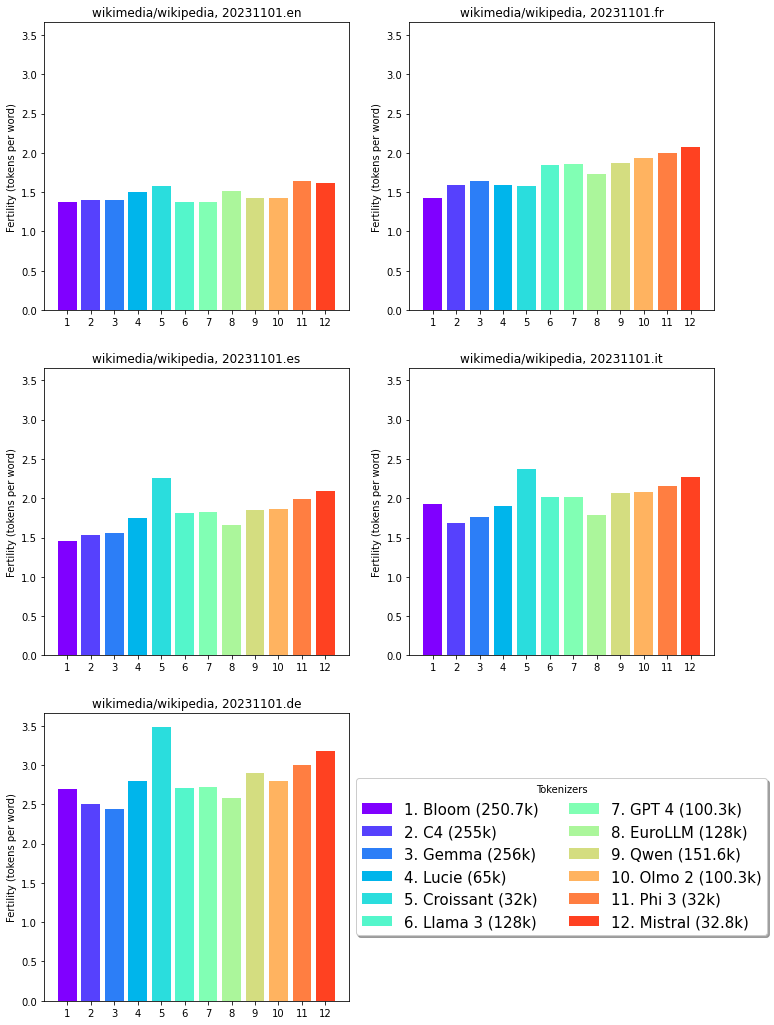

In [146]:
# clear_cache()

benchmark_fertility(
    [
        ("wikimedia/wikipedia", "20231101." + lan)
        for lan in ["en", "fr", "es", "it", "de"]
    ],
    ["GPT 4", "Gemma", "Phi 3", "Mistral", "Llama 3", "Qwen", "Bloom", "Croissant", "EuroLLM", "Lucie", "C4", "Olmo 2"]
)

<h3 id="templates">🔢💬 Chat templates</h3>

Since LLM are often used for chatbot applications,
models are often trained on dialogues, with a particular pattern to indicate speech turns, involving special tokens/tags. <br>
This templating can be as a pre-processing step of the model, and it is usually stored with the tokenizer.

In [147]:
show_templates(
    ["Mistral", "Zephyr", "Olmo 2", "Llama 3", "OpenLLM-France/Lucie-7B-Baby-Instruct"]
)


👤 Mistral:
------------
<s>[INST] Hello robot[/INST] Hello human! How can I help?</s>[INST] Make me a coffee[/INST]
💬 <BOS>┃[INST] ┃《…》
💬 [/INST] ┃《…》
💬 <EOS> 

👤 Zephyr:
-----------
<|user|>
Hello robot</s>
<|assistant|>
Hello human! How can I help?</s>
<|user|>
Make me a coffee</s>

💬 ▁<┃|┃user┃|┃>┃\n┃. ┃《…》
💬 <EOS>┃▁┃\n┃<┃|┃ass┃istant┃|┃>┃\n┃. ┃《…》
💬 <EOS>┃▁┃\n 

👤 Olmo 2:
-----------
<|endoftext|><|user|>
Hello robot
<|assistant|>
Hello human! How can I help?<|endoftext|>
<|user|>
Make me a coffee

💬 <EOS>┃<┃|┃user┃|┃>┃\n ┃《…》
💬 \n┃<┃|┃assistant┃|┃>┃\n ┃《…》
💬 <EOS> 

👤 Llama 3:
------------
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

Hello robot<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Hello human! How can I help?<|eot_id|><|start_header_id|>user<|end_header_id|>

Make me a coffee<|eot_id|>
💬 <BOS>┃<start_header_id>┃user┃<end_header_id>┃\n\n ┃《…》
💬 <eot_id>┃<start_header_id>┃assistant┃<end_header_id>┃\n\n ┃《…》
💬 <eot_id> 

👤 OpenLLM-France/Lucie-7B-Ba

**Experience feedback:**
* It seems better to have tags to indicate both the start AND the end of each "speech turn", so that the model can learn more easily to stop generating text.
* ⚠️ Using the wrong template (mismatch between training and inference) can lead the LLM
   * to generate text that is not coherent with the context,
   * to stop answering prematurely,
   * to generate special stags from the pattern.

Templates can come in different formats, and for those previous reasons it is important to provide/use a good template setup. <br>
* With `tokenizers`/`transformers`, the template is stored in a JSON file [`tokenizer_config.json`](https://huggingface.co/meta-llama/Meta-Llama-3-8B-Instruct/blob/main/tokenizer_config.json):
```json	
{
  "chat_template": "{% set loop_messages = messages %}{% for message in loop_messages %}{% set content = '<|start_header_id|>' + message['role'] + '<|end_header_id|>\n\n'+ message['content'] | trim + '<|eot_id|>' %}{% if loop.index0 == 0 %}{% set content = bos_token + content %}{% endif %}{{ content }}{% endfor %}{% if add_generation_prompt %}{{ '<|start_header_id|>assistant<|end_header_id|>\n\n' }}{% endif %}",
}
```
* With [ollama](https://ollama.com/), parameter `TEMPLATE` in the [`Modelfile`](https://github.com/ollama/ollama/blob/main/docs/modelfile.md#format) is in GO format:
```go
TEMPLATE """{{ if .System }}<|start_header_id|>system<|end_header_id|>

{{ .System }}<|eot_id|>{{ end }}{{ if .Prompt }}<|start_header_id|>user<|end_header_id|>

{{ .Prompt }}<|eot_id|>{{ end }}<|start_header_id|>assistant<|end_header_id|>

{{ .Response }}<|eot_id|>"""
```


<h3 id="padding">🔢✂️ Padding and Truncation</h3>

Padded is needed when processing <u>batch of variable-length sequences</u>.
<br> When training a LLM, with a fixed context length, sequences of tokens are either packed (for efficiency) or padded/truncated to the context length (and losses have to be masked accordingly).

Padding can be
* added on the left or on the right (if on the left, be careful with auto-regressive LLMs, to use the right causal mask)
* done with a value that is a special dedicated token `<pad>`, or simply the `<EOS>` token (end of sequence).


In [232]:
for name in [
    "Qwen",
    "Lucie"
]:
    tokenizer = load_tokenizer_with_cache(name)
    print(f"🧮 {name} does pad on the {tokenizer.padding_side}")


test_tokenizers(
    "Bonjour",
    ["Olmo 2", "Qwen", "Zephyr", "Bloom", "C4", "Lucie"],
    display_fertility=False,
    # 👇 Options for padding (with tokenizers lib)
    padding='max_length', truncation=True, max_length=7,
)

# Note: with "Llama 3", "Llama 2", "Falcon", "EuroLLM", ... padding should be set explicitly
#   ValueError: Asking to pad but the tokenizer does not have a padding token.
#   Please select a token to use as `pad_token` `(tokenizer.pad_token = tokenizer.eos_token e.g.)


🧮 Qwen does pad on the right
🧮 Lucie does pad on the left


,tokenizer,size,round-trip,encoded tokens,decoded text
0,Olmo 2,100.3k,✅,Bonjour┃<pad>┃<pad>┃<pad>┃<pad>┃<pad>┃<pad>,Bonjour<pad><pad><pad><pad><pad><pad>
1,Qwen,151.6k,✅,Bonjour┃<EOS>┃<EOS>┃<EOS>┃<EOS>┃<EOS>┃<EOS>,Bonjour<EOS><EOS><EOS><EOS><EOS><EOS>
2,Zephyr,32k,✅,<EOS>┃<EOS>┃<EOS>┃<BOS>┃▁Bon┃jour┃<EOS>,<EOS><EOS><EOS><BOS> Bonjour<EOS>
3,Bloom,250.7k,✅,<pad>┃<pad>┃<pad>┃<pad>┃<pad>┃<pad>┃Bonjour,<pad><pad><pad><pad><pad><pad>Bonjour
4,C4,255k,✅,<pad>┃<pad>┃<pad>┃<BOS>┃Bon┃jour┃<EOS>,<pad><pad><pad><BOS>Bonjour<EOS>
5,Lucie,65k,✅,<pad>┃<pad>┃<pad>┃<pad>┃<BOS>┃▁Bonjour┃<EOS>,<pad><pad><pad><pad><BOS> Bonjour<EOS>


<h3 id="training">🤖🧠 Train a new tokenizer</h3>

You need to collect a dataset of text data to train a new tokenizer.
<br>*How much?*
[Lucie tokenizer](https://huggingface.co/OpenLLM-France/Lucie-7B) was done on 2.78B words of text in French, English, German, Spanish and Italian [(see details here)](https://github.com/OpenLLM-France/Lucie-Training/blob/master/chronicles/tokenization/stats_train_tokenizer.csv).


Below is a super simple example, where you can see how tokens are chosen, in order:

In [9]:
import tokenizers

text = "si ton tonton tond ton tonton, ton tonton sera tondu."

num_unique_chars = len(set(text)) # 13 unique characters in the text

sorted_tokens = []
for vocab_size in range(num_unique_chars, num_unique_chars+10):
    tokenizer = tokenizers.Tokenizer(
        tokenizers.models.BPE(
            dropout=None,
            unk_token="<unk>",
            fuse_unk=True,
            byte_fallback=True,
        )
    )
    def text_iterator():
        yield text
    tokenizer.train_from_iterator(
        text_iterator(),
        trainer=tokenizers.trainers.BpeTrainer(
            vocab_size=vocab_size,
            show_progress=False,
        )
    )
    for token in get_vocabulary(tokenizer):
        if token not in sorted_tokens:
            sorted_tokens.append(token)

pd.DataFrame(sorted_tokens, index = range(1, len(sorted_tokens)+1), columns=["Token"])

,Token
1,▁
2,","
3,.
4,a
5,d
6,e
7,i
8,n
9,o
10,r


In [10]:
sorted_vocabulary(tokenizer)

,nchars,start,#tokens,tokens
0,0,▶,1,[▁]
1,1,#…,12,"[,, ., a, d, e, i, n, o, r, s, t, u]"
2,1,▶,1,[▁s]
3,2,#…,1,[on]
4,3,#…,1,[ton]
5,3,▶,1,[▁ton]
6,4,▶,1,[▁tond]
7,6,#…,1,[a▁tond]
8,6,▶,1,[▁tonton]
9,10,▶,1,[▁ton▁tonton]


Note that it is impossible to have a token with 3 characters ("ton") without having some sub-tokens with less characters to generate it ("t" and "on" here).

BPE works like this. The order of the tokens in the vocabulary has an influence (it is a priority), and tokens are glued in a greedy fashion to compose new tokens.
<br>The goal being to minimize fertility for the given vocabulary size.

Some scripts to train a tokenizer:
* with `tiktoken` library
  * [openai does not plan to open the code to train...](https://github.com/openai/tiktoken/issues/25)
* with `sentencepiece`
  * ... TODO ...
* with `tokenizers` library:
  * [`tokenizer_train.py`@OpenLLM-France/Lucie-Training](https://github.com/OpenLLM-France/Lucie-Training/blob/master/tokenization/tokenizer_train.py)

In practice, when designing/training a new tokenizer, the devil is in the details.

Look at all options in the script [`tokenizer_train.py`@OpenLLM-France/Lucie-Training](https://github.com/OpenLLM-France/Lucie-Training/blob/master/tokenization/tokenizer_train.py):
```bash
python3 tokenizer_train.py -h
```
```plaintext
usage: tokenizer_train.py [-h] [--vocab_size VOCAB_SIZE] [--base BASE] [--individual_digits INDIVIDUAL_DIGITS] [--consecutive_spaces CONSECUTIVE_SPACES] [--consecutive_tabs CONSECUTIVE_TABS]
                          [--consecutive_linebreaks CONSECUTIVE_LINEBREAKS] [--space_behaviour {prefix_all,prefix_sos,split}] [--separate_punctuation SEPARATE_PUNCTUATION] [--enforce_alphabet ENFORCE_ALPHABET] [--output OUTPUT]        
                          [--overwrite] [--debug] [--no_verbose]

Train a tokenizer.

options:
  -h, --help            show this help message and exit
  --vocab_size VOCAB_SIZE
                        Size of output vocabulary (ex: 32000, 65024, ...) (default: 65024)
  --base BASE           Base tokenizer (ex: mistralai/Mistral-7B-v0.1) (default: None)
  --individual_digits INDIVIDUAL_DIGITS
                        Split digits individually (ex: 1999 -> 1┃9┃9┃9) (default: True)
  --consecutive_spaces CONSECUTIVE_SPACES
                        Maximum number of consecutive spaces (in a same token) (default: 8)
  --consecutive_tabs CONSECUTIVE_TABS
                        Maximum number of consecutive tabs (in a same token) (default: 4)
  --consecutive_linebreaks CONSECUTIVE_LINEBREAKS
                        Maximum number of consecutive linebreaks (in a same token) (default: 2)
  --space_behaviour {prefix_all,prefix_sos,split}
                        How to deal with whitespaces (default: prefix_all)
  --separate_punctuation SEPARATE_PUNCTUATION
                        Make sure not to mix spaces and punctuations with alphanumeric characters (default: True)
  --enforce_alphabet ENFORCE_ALPHABET
                        Restrict the alphabet of unicode characters (avoiding 'exotic' characters) (default: True)
  --output OUTPUT, -o OUTPUT
                        Output folder (will be set automatically if not specified) (default: None)
  --overwrite           Overwrite output folder if it already exists (default: False)
  --debug               Debug mode (default: False)
  --no_verbose
  ```

<h3 id="surgery">🤖👩🏻‍⚕️ Tokenizer Surgery</h3>

A tokenizer can be modified by
* Adding new tokens (sometimes special tokens)
* Removing some tokens (very seldom...)
* Changing some options (padding side)
* Adding new templates

Doing this can be a mess, more than expected...
It turns out than modifying JSON files (programmatically) is rather a good way to do all this...